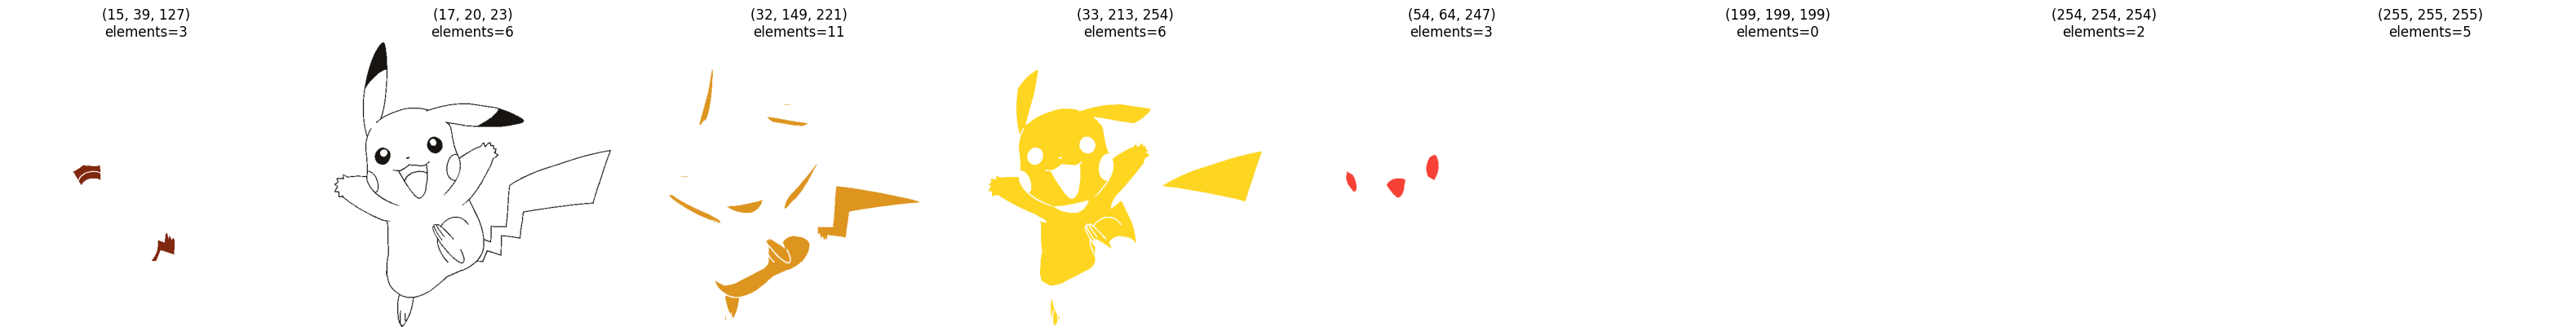

Color (15, 39, 127): 3 distinct elements
Color (17, 20, 23): 6 distinct elements
Color (32, 149, 221): 11 distinct elements
Color (33, 213, 254): 6 distinct elements
Color (54, 64, 247): 3 distinct elements
Color (199, 199, 199): 0 distinct elements
Color (254, 254, 254): 2 distinct elements
Color (255, 255, 255): 5 distinct elements
Total elements: 36


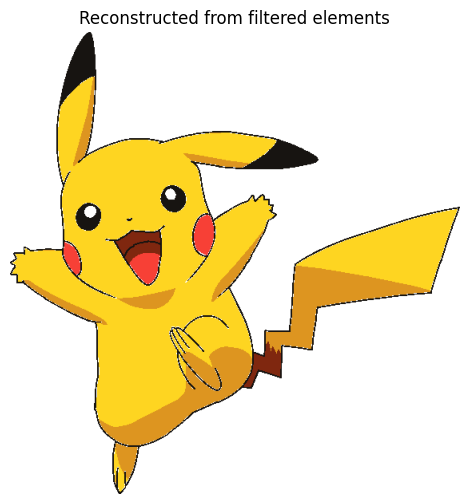

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# CELL 1: Per‑color filtered elements visualization + reconstruction
# ──────────────────────────────────────────────────────────────────────────────
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1) Load your quantized image
path = "Pikachu_quant.png"    # adjust as needed
img = cv2.imread(path)
bgr = img[:, :, :3]

# 2) Build the palette of unique colors
palette = np.unique(bgr.reshape(-1, 3), axis=0).tolist()

# 3) Set retrieval & approximation (not used for filling, but kept for contour count)
mode   = cv2.RETR_TREE
method = cv2.CHAIN_APPROX_SIMPLE

# 4) Prepare subplots: one per color
n_colors = len(palette)
fig, axes = plt.subplots(1, n_colors,
                         figsize=(4 * n_colors, 4),
                         constrained_layout=True)
if n_colors == 1:
    axes = [axes]

# 5) Containers for totals and elements
elements_by_color = {}
MIN_SIZE = 10  # minimum pixel count to keep

# 6) Loop per color
for ax, colour in zip(axes, palette):
    col = tuple(int(c) for c in colour)
    # mask that color
    mask = cv2.inRange(bgr, np.array(col), np.array(col))

    # connected components → distinct elements (hole‑free)
    num_labels, labels = cv2.connectedComponents(mask)
    elements = []
    for lbl in range(1, num_labels):
        comp_mask = (labels == lbl).astype(np.uint8) * 255
        if cv2.countNonZero(comp_mask) <= MIN_SIZE:
            continue
        elements.append(comp_mask)
    elements_by_color[col] = elements

    # build a white canvas, then fill each kept element
    canvas = np.full_like(bgr, 255)
    for comp_mask in elements:
        canvas[comp_mask.astype(bool)] = col

    # display per‑color filtered elements
    ax.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    ax.set_title(f"{col}\nelements={len(elements)}")
    ax.axis("off")

plt.show()

# 7) print element counts
total_elements = sum(len(elems) for elems in elements_by_color.values())
for col, elems in elements_by_color.items():
    print(f"Color {col}: {len(elems)} distinct elements")
print(f"Total elements: {total_elements}")

# 8) Reconstruct full image from extracted elements
recon = np.full_like(bgr, 255)
for col, elems in elements_by_color.items():
    for comp_mask in elems:
        recon[comp_mask.astype(bool)] = col

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(recon, cv2.COLOR_BGR2RGB))
plt.title("Reconstructed from filtered elements")
plt.axis("off")
plt.show()


Element summary (id → parent, depth, area, peri):
    3 →   -, d=0, area=107390, peri=2936
   32 →   -, d=0, area=96676, peri=2124
   33 →   -, d=0, area=72771, peri=1477
   35 →   -, d=0, area=27120, peri=777
   31 →   -, d=0, area=17673, peri=763
   34 →   -, d=0, area=19, peri=26
   10 →   -, d=0, area=0, peri=26
   20 →   3, d=1, area=64410, peri=2812
   21 →   3, d=1, area=9847, peri=526
   17 →   3, d=1, area=7212, peri=789
   14 →   3, d=1, area=6785, peri=614
    2 →   3, d=1, area=966, peri=218
   26 →   3, d=1, area=899, peri=127
   12 →   3, d=1, area=788, peri=235
   15 →   3, d=1, area=782, peri=270
    9 →   3, d=1, area=738, peri=245
   18 →   3, d=1, area=688, peri=133
   11 →   3, d=1, area=512, peri=176
   27 →   3, d=1, area=482, peri=101
   24 →   3, d=1, area=264, peri=153
   23 →   3, d=1, area=75, peri=57
   22 →   3, d=1, area=51, peri=66
   25 →   3, d=1, area=5, peri=12
   19 →   3, d=1, area=1, peri=21
   13 →  31, d=1, area=0, peri=28
    7 →  20, d=2, area=

C:\Users\adamk\AppData\Local\Temp\ipykernel_16952\1279008591.py:109: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  depth_cmap = plt.cm.get_cmap("tab10")


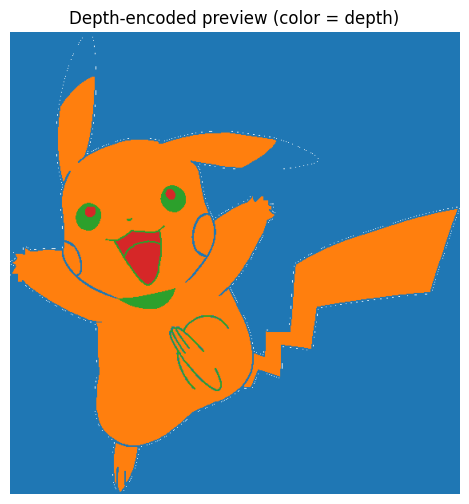

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# CELL 2: Layering
# ──────────────────────────────────────────────────────────────────────────────

import cv2, numpy as np, matplotlib.pyplot as plt, math, pprint

# ------------------------------------------------------------------ 0. Inputs
# Reload image (or use existing bgr from previous cell)
path = "Pikachu_quant.png"
img  = cv2.imread(path)
bgr  = img[:, :, :3]
h, w = bgr.shape[:2]

# Must have run the filtered‐elements extraction cell already:
# elements_by_color: dict mapping BGR tuple → list of binary masks
try:
    elements_by_color
except NameError:
    raise ValueError("You need to run the cell that builds elements_by_color first!")

# ------------------------------------------------------------------ 1. Create element list from masks
elements = []           # list of dicts
id_map   = {}           # contour id → element dict

for colour, masks in elements_by_color.items():
    for comp_mask in masks:
        # extract the single external contour for this component
        cnts, _ = cv2.findContours(comp_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if not cnts:
            continue
        cnt = cnts[0]

        # compute properties
        area     = cv2.contourArea(cnt)
        peri     = cv2.arcLength(cnt, True)
        M        = cv2.moments(cnt)
        centroid = np.array([
            M["m10"] / max(M["m00"], 1e-6),
            M["m01"] / max(M["m00"], 1e-6)
        ])

        elem = dict(
            id        = len(elements),
            colour    = colour,
            contour   = cnt,
            area      = area,
            perimeter = peri,
            centroid  = centroid,
            parent    = None,
            children  = [],
            depth     = None
        )
        elements.append(elem)
        id_map[id(cnt)] = elem

if not elements:
    raise ValueError("No elements found—check your elements_by_color masks!")

# ------------------------------------------------------------------ 2. Pre-cache bounding boxes
for e in elements:
    x, y, bw, bh = cv2.boundingRect(e["contour"])
    e["bbox"] = (x, y, bw, bh)

# ------------------------------------------------------------------ 3. Detect parent–child relationships
for inner in elements:
    best_parent    = None
    best_area_diff = float("inf")
    xi, yi, wi, hi = inner["bbox"]

    for outer in elements:
        if outer["area"] <= inner["area"]:
            continue
        xo, yo, wo, ho = outer["bbox"]
        # fast bbox containment
        if xo > xi or yo > yi or xo+wo < xi+wi or yo+ho < yi+hi:
            continue
        # precise: centroid inside outer?
        if cv2.pointPolygonTest(outer["contour"],
                                tuple(inner["centroid"]),
                                False) < 0:
            continue

        diff = outer["area"] - inner["area"]
        if diff < best_area_diff:
            best_area_diff = diff
            best_parent    = outer

    if best_parent is not None:
        inner["parent"] = best_parent["id"]
        best_parent["children"].append(inner["id"])

# ------------------------------------------------------------------ 4. Assign depths (roots = 0)
def set_depth(e, d):
    e["depth"] = d
    for cid in e["children"]:
        set_depth(elements[cid], d+1)

for e in elements:
    if e["parent"] is None:
        set_depth(e, 0)

# ------------------------------------------------------------------ 5. Layering heuristic & summary
layer_order = sorted(elements, key=lambda e: (e["depth"], -e["area"]))
print("Element summary (id → parent, depth, area, peri):")
for e in layer_order:
    print(f"  {e['id']:>3} → {e['parent'] if e['parent'] is not None else '-':>3},"
          f" d={e['depth']}, area={e['area']:.0f}, peri={e['perimeter']:.0f}")

# ------------------------------------------------------------------ 6. Visual check – color‑coded by depth
depth_cmap = plt.cm.get_cmap("tab10")
canvas = np.full((h, w, 3), 255, np.uint8)
for e in layer_order:
    color_idx = e["depth"] % 10
    fake_color = tuple(int(c*255) for c in depth_cmap(color_idx)[:3][::-1])
    cv2.drawContours(canvas, [e["contour"]], -1, fake_color, cv2.FILLED)

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.title("Depth‑encoded preview (color = depth)")
plt.axis("off")
plt.show()

# ------------------------------------------------------------------ 7. (Optional) inspect elements
# pprint.pprint(elements[:5])


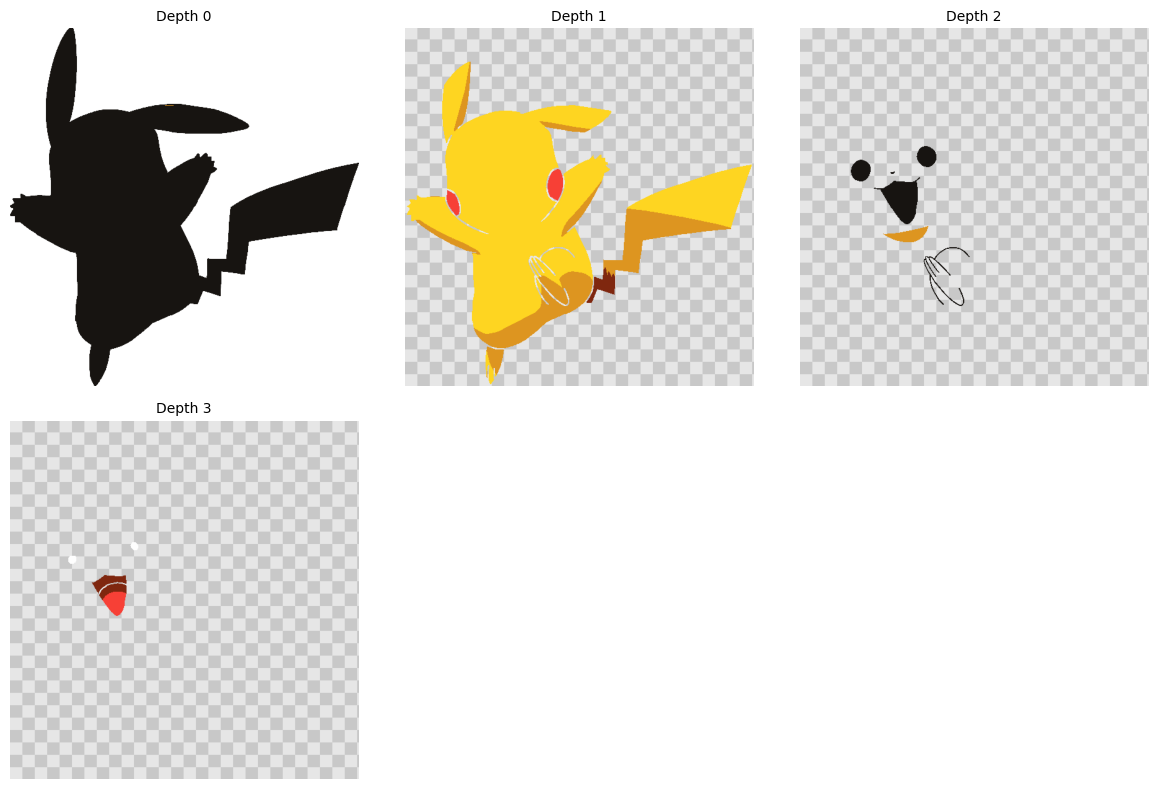

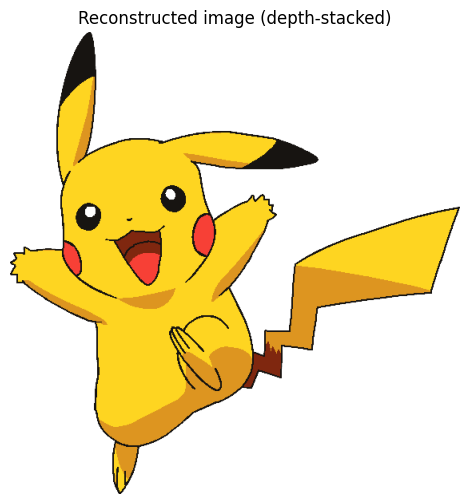

In [ ]:

# ==============================================================================
# CELL 3:  Depth previews + final reconstruction (using filtered elements)
# ==============================================================================
import cv2, numpy as np, matplotlib.pyplot as plt, math

# --- 0. Sanity checks ---------------------------------------------------------
# 'elements' should have been built in the ancestry cell from elements_by_color
if "elements" not in globals() or not elements or any(e.get("depth") is None for e in elements):
    raise ValueError("Run the ancestry cell first – no 'elements' with depth available!")

# --- 0.5 Determine image size -------------------------------------------------
# Either reuse loaded_image_data if available, or reload the quant image

path = "Pikachu_quant.png" 
img = cv2.imread(path)
h, w = img.shape[:2]

# --- 1. Helper – checkerboard background -------------------------------------
def make_checkerboard(height, width, block=20,
                      color_a=(230, 230, 230), color_b=(200, 200, 200)):
    yy, xx = np.indices((height, width))
    pattern = ((yy // block) + (xx // block)) % 2
    board   = np.empty((height, width, 3), np.uint8)
    board[pattern == 0] = color_a
    board[pattern == 1] = color_b
    return board

# --- 2. Create one canvas per depth ------------------------------------------
depth_levels   = sorted({e["depth"] for e in elements})
depth_canvases = []  # list of (depth, BGR image)

for d in depth_levels:
    canvas = make_checkerboard(h, w)
    for e in elements:
        if e["depth"] == d:
            # draw the filled contour in its original color
            cv2.drawContours(canvas, [e["contour"]], -1, e["colour"], cv2.FILLED)
    depth_canvases.append((d, canvas))

# --- 3. Display depth previews -----------------------------------------------
cols = 3
rows = math.ceil(len(depth_canvases) / cols)
plt.figure(figsize=(cols * 4, rows * 4))

for idx, (d, img_bgr) in enumerate(depth_canvases, 1):
    plt.subplot(rows, cols, idx)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.title(f"Depth {d}", fontsize=10)
    plt.axis("off")

# blank out any extra subplots
for blank in range(idx + 1, rows * cols + 1):
    plt.subplot(rows, cols, blank); plt.axis("off")

plt.tight_layout()
plt.show()

# --- 4. Final reconstructed image (paint depth 0 → max) ----------------------
reconstructed = make_checkerboard(h, w)

for d in depth_levels:
    for e in elements:
        if e["depth"] == d:
            cv2.drawContours(reconstructed, [e["contour"]], -1, e["colour"], cv2.FILLED)

plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(reconstructed, cv2.COLOR_BGR2RGB))
plt.title("Reconstructed image (depth‑stacked)")
plt.axis("off")
plt.show()


In [17]:
# ──────────────────────────────────────────────────────────────────────────────
# CELL N+4: Export ALL elements into a single combined SVG,
#           drawing in depth order so viewers layer correctly
# ──────────────────────────────────────────────────────────────────────────────
import os
import cv2
import numpy as np

# ──────────────────────────────────────────────────────────────────────────────
# Helpers
# ──────────────────────────────────────────────────────────────────────────────
def contour_to_svg_path(cnt):
    pts = cnt.reshape(-1, 2)
    if len(pts) == 0:
        return ""
    return (
        f"M {pts[0][0]} {pts[0][1]} "
        + " ".join(f"L {x} {y}" for x, y in pts[1:])
        + " Z"
    )

def bgr_to_hex(bgr):
    r, g, b = bgr[2], bgr[1], bgr[0]
    return f"#{r:02x}{g:02x}{b:02x}"

# ──────────────────────────────────────────────────────────────────────────────
# Prepare output
# ──────────────────────────────────────────────────────────────────────────────
output_folder = "exported_svgs"
os.makedirs(output_folder, exist_ok=True)
output_file = os.path.join(output_folder, "all_elements_depth_sorted.svg")

# ──────────────────────────────────────────────────────────────────────────────
# Image dimensions
# ──────────────────────────────────────────────────────────────────────────────
if "loaded_image_data" in globals():
    img_w = loaded_image_data["width"]
    img_h = loaded_image_data["height"]
else:
    img = cv2.imread("Pikachu_quant.png")  # adjust as needed
    img_h, img_w = img.shape[:2]

# ──────────────────────────────────────────────────────────────────────────────
# Build combined SVG content, sorting by depth ascending
# ──────────────────────────────────────────────────────────────────────────────
svg_header = f'''<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<svg xmlns="http://www.w3.org/2000/svg"
     width="{img_w}" height="{img_h}"
     viewBox="0 0 {img_w} {img_h}">
'''

# sort elements so depth=0 drawn first, then depth=1, etc.
sorted_elems = sorted(elements, key=lambda e: e["depth"])

svg_groups = []
for elem in sorted_elems:
    cnt   = elem["contour"]
    col   = elem["colour"]
    eid   = elem["id"]
    depth = elem.get("depth", 0)
    area  = elem.get("area", 0.0)

    d = contour_to_svg_path(cnt)
    if not d:
        continue

    x, y, w, h = cv2.boundingRect(cnt)
    title = f"Element {eid} (depth {depth}, color {col})"
    desc  = f"bbox: x={x},y={y},w={w},h={h}; area={area:.1f}"
    fill_hex = bgr_to_hex(col)

    # include a data‑depth attribute for clarity
    group = f'''  <g id="elem_{eid}" data-depth="{depth}">
    <title>{title}</title>
    <desc>{desc}</desc>
    <path d="{d}" fill="{fill_hex}" stroke="none"/>
  </g>'''
    svg_groups.append(group)

svg_footer = "\n</svg>\n"

# ──────────────────────────────────────────────────────────────────────────────
# Write single SVG
# ──────────────────────────────────────────────────────────────────────────────
with open(output_file, "w", encoding="utf-8") as f:
    f.write(svg_header)
    f.write("\n".join(svg_groups))
    f.write(svg_footer)

print(f"Exported combined SVG with {len(svg_groups)} elements (depth‑sorted) to '{output_file}'")


Exported combined SVG with 36 elements (depth‑sorted) to 'exported_svgs\all_elements_depth_sorted.svg'
